<a href="https://colab.research.google.com/github/dalfonsoa/Inteligencai_Artificial/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydap
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b13e112eae6a2fec83a94605825244a466d2cab2c37e9ff3a728c3d8ab143024
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 85.2 MB/s eta 0:00:00


In [ ]:
## Import Modules
from IPython.display import IFrame
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy
import pydap
import getpass
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pandas as pd
import numpy as np
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# definir clases y funciones
# crear un objeto data_set
class CustomDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# definir la clase de autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        # Flatten antes de la capa lineal
        self.flatten = nn.Flatten()

        # Linear layer para producir el vector latente
        self.latent = nn.Linear(512 * 4 * 4, latent_size)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 512 * 4 * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Unflatten(1, (512, 4, 4)),  # Inverso de Flatten
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        #print("Encoder output shape:", x.shape)
        x = self.flatten(x)
        #print("Flatten output shape:", x.shape)
        latent_vector = self.latent(x)
        #print("Latent vector shape:", latent_vector.shape)
        reconstructed = self.decoder(latent_vector)
        return reconstructed, latent_vector



# Define el entrenador
class AutoencoderTrainer:
    def __init__(self, model, dataloaders, num_epochs=10, learning_rate=0.001):
        self.model = model
        self.dataloaders = dataloaders
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.num_epochs = num_epochs
        self.train_losses = []
        self.val_losses = []

    def train(self):
        for epoch in range(self.num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.dataloaders['train']
                else:
                    self.model.eval()
                    dataloader = self.dataloaders['val']

                running_loss = 0.0

                for inputs in dataloader:

                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs, _ = self.model(inputs)

                        loss = self.criterion(outputs, inputs)

                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    running_loss += loss.item()

                epoch_loss = running_loss / len(dataloader.dataset)

                # Almacena la pérdida en el conjunto de entrenamiento o validación
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                else:
                    self.val_losses.append(epoch_loss)

            # Imprime la pérdida al final de cada época
            print(f'Epoch {epoch + 1}/{self.num_epochs}, Train Loss: {self.train_losses[-1]}, Val Loss: {self.val_losses[-1]}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data location
ROOT_DIR = "/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis"
DATA_DIR = "DATA"
DATA = "reanalysis_pacifico_thetao.nc"

In [ ]:
path_data=os.path.join("/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis", "DATA", "reanalysis_pacifico_thetao.nc")

In [ ]:
DS_pacifico = xr.open_dataset(path_data).loc[dict(longitude=slice(-86.3,-81), latitude=slice(0,5.3))]
DS_pacifico.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (depth: 1, latitude: 64, time: 10227, longitude: 64)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 0.0 0.08333 0.1667 0.25 ... 5.083 5.167 5.25
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-12-31T12:00:00
  * longitude  (longitude) float32 -86.25 -86.17 -86.08 ... -81.17 -81.08 -81.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2022/05/25 21:54:07 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__lat

In [ ]:
# plotear anualmente y mensualmente pacifico
month_temp_pacifico = DS_pacifico.thetao.groupby("time.month").mean()

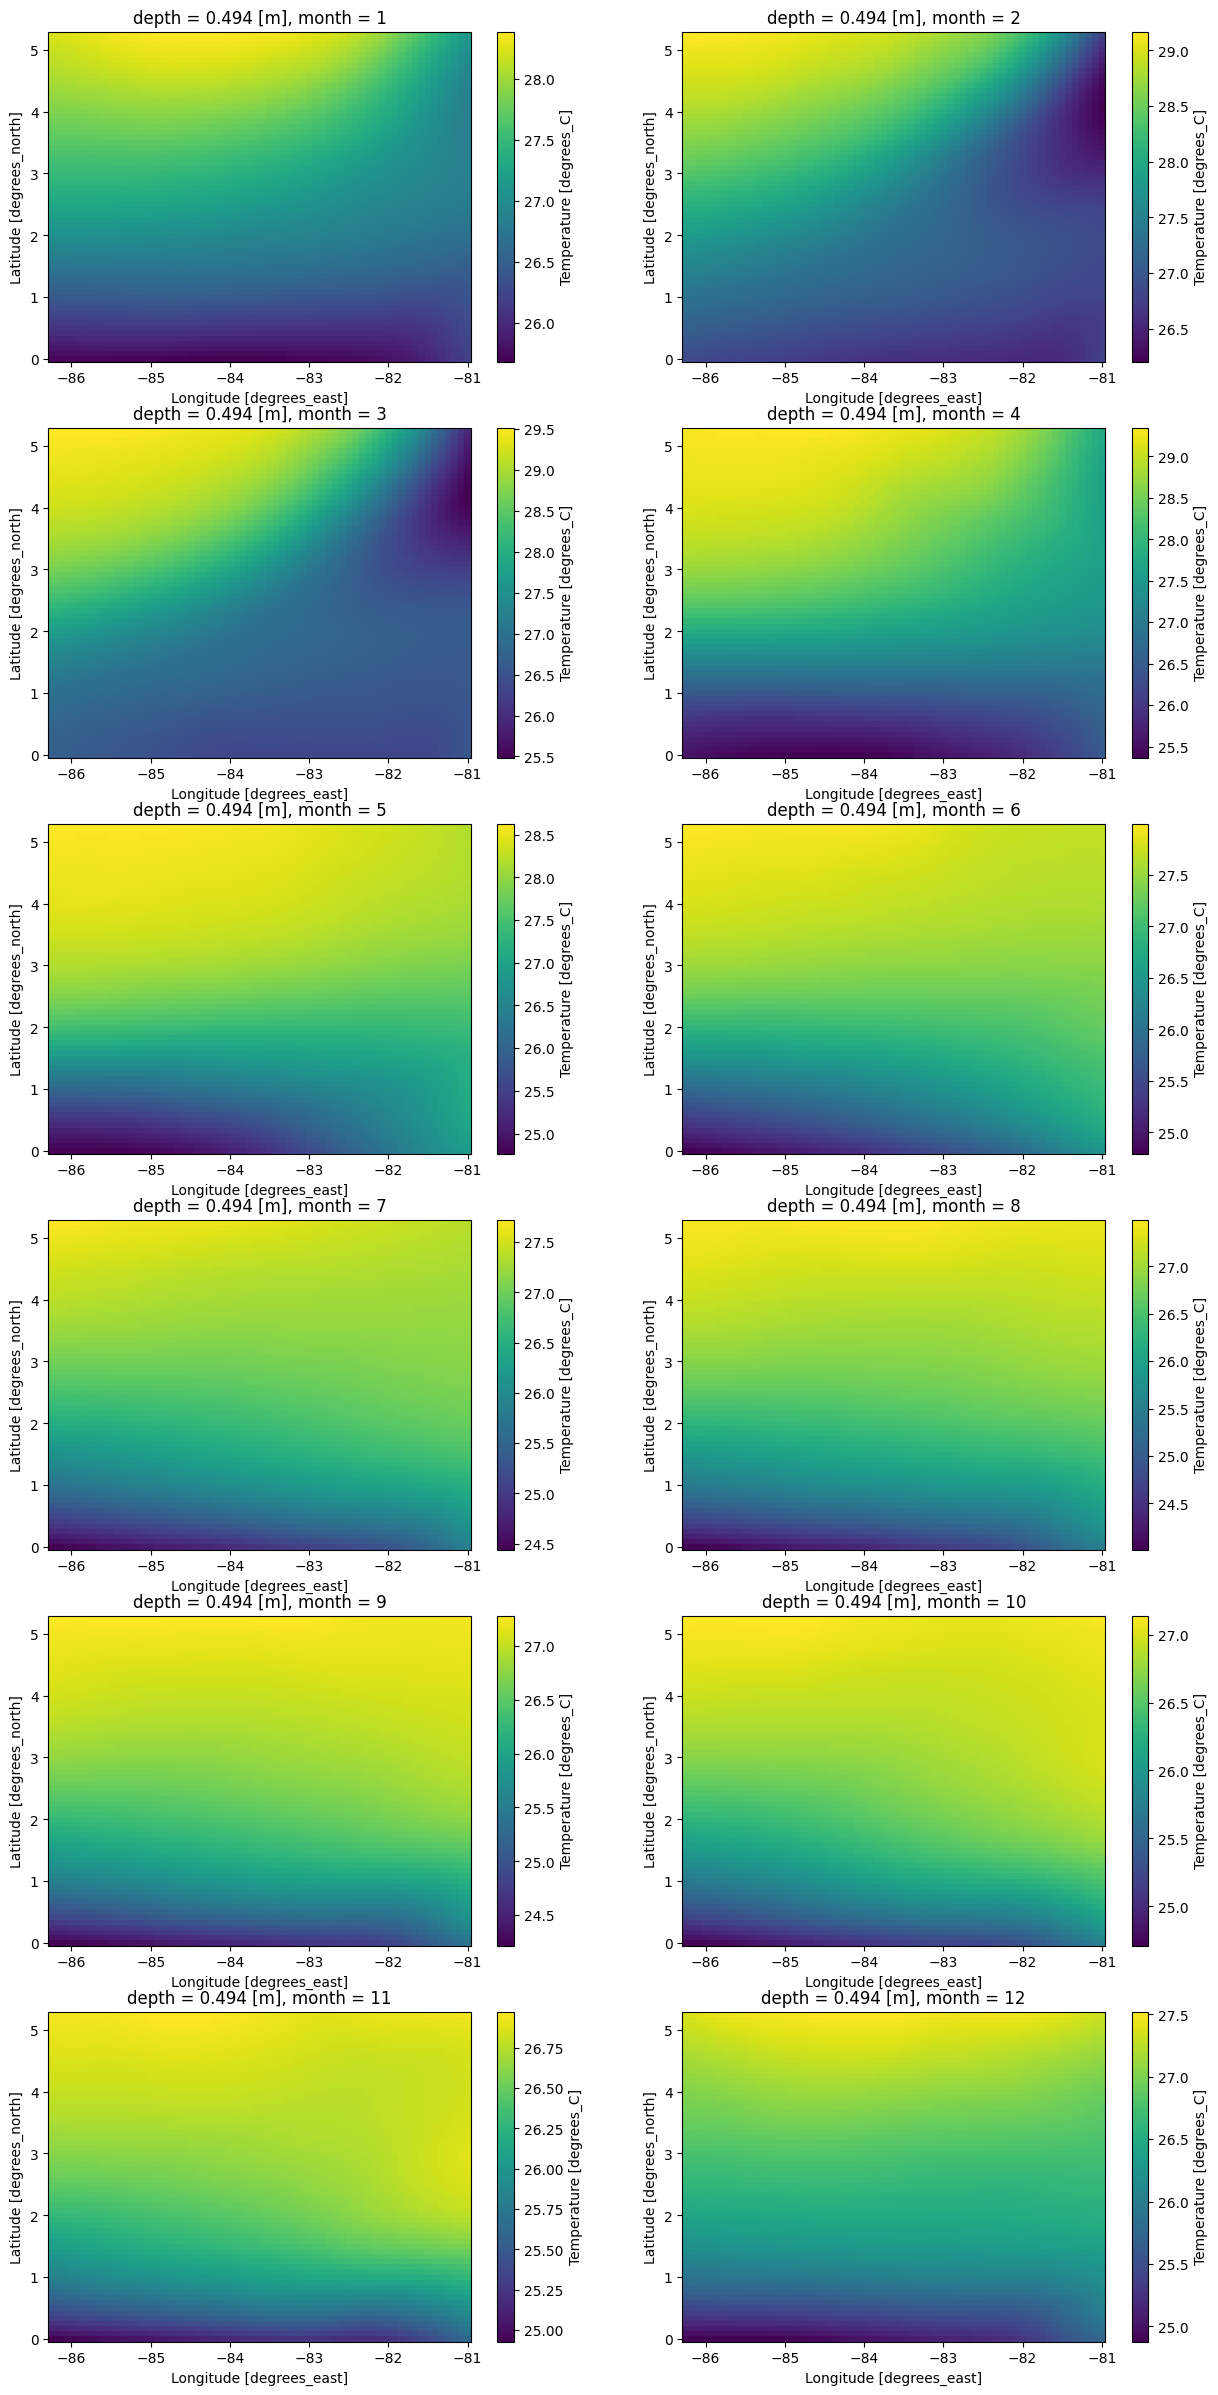

In [ ]:
# ploteo mensual pacifico
f, axs = plt.subplots(6,2, figsize = (15,30))
axs = axs.flatten()
for i, ax in enumerate(axs):
    month_temp_pacifico.sel(month=i+1, method = 'nearest').plot(ax = axs[i])

In [ ]:
mean_date = DS_pacifico.groupby("time").mean(dim=["depth", "latitude", "longitude"]).thetao.values
min_date = DS_pacifico.groupby("time").min(dim=["depth", "latitude", "longitude"]).thetao.values
max_date = DS_pacifico.groupby("time").max(dim=["depth", "latitude", "longitude"]).thetao.values
time_axis = DS_pacifico.time.values

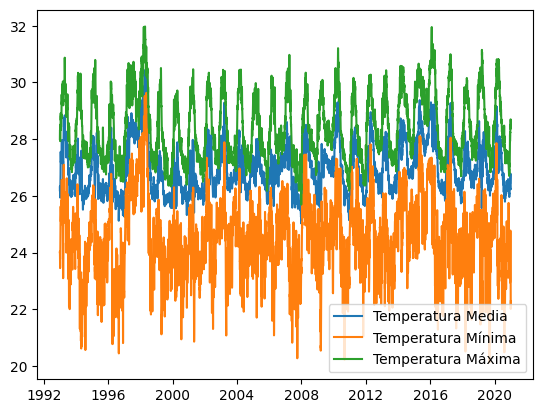

In [ ]:
plt.plot(time_axis, mean_date, label = "Temperatura Media")
plt.plot(time_axis, min_date, label = "Temperatura Mínima")
plt.plot(time_axis, max_date, label = "Temperatura Máxima")
plt.legend()
plt.show()

In [ ]:
DS_normal = deepcopy(DS_pacifico)
thetao_min = DS_normal["thetao"].min()
thetao_max = DS_normal["thetao"].max()
DS_normal["thetao_normalized"] = (DS_normal["thetao"] - thetao_min)/(thetao_max - thetao_min)
DS_normal.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:            (depth: 1, latitude: 64, time: 10227, longitude: 64)
Coordinates:
  * depth              (depth) float32 0.494
  * latitude           (latitude) float32 0.0 0.08333 0.1667 ... 5.167 5.25
  * time               (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-12-...
  * longitude          (longitude) float32 -86.25 -86.17 -86.08 ... -81.08 -81.0
Data variables:
    thetao             (time, depth, latitude, longitude) float32 24.37 ... 2...
    thetao_normalized  (time, depth, latitude, longitude) float32 0.3585 ... ...
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2022/05/25 21:54:07 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    ...

In [ ]:
# defincion de los dataset
thetao_tensor = torch.tensor(DS_normal["thetao_normalized"].values, dtype=torch.float32)
thetao_dataset = CustomDataset(thetao_tensor)

In [ ]:
# Define los tamaños de los conjuntos
total_size = len(thetao_dataset)
train_size = int(0.7 * total_size)  # 70% para entrenamiento
val_size = int(0.2 * total_size)    # 20% para validación
test_size = total_size - train_size - val_size  # El resto para prueba

# Divide el conjunto de datos
train_dataset, val_dataset, test_dataset = random_split(thetao_dataset, [train_size, val_size, test_size])

# Crea DataLoaders para los conjuntos de entrenamiento, validación y prueba
batch_size = 64  # Elige el tamaño del lote que desees
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
# Crea un diccionario con los DataLoaders
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
# Definir parámetros para las capas convolucionales
autoencoder = Autoencoder(latent_size=64)
# Crea una instancia del entrenador
trainer = AutoencoderTrainer(model=autoencoder, dataloaders=dataloaders, num_epochs=10, learning_rate=0.001)


In [ ]:
# Entrena el modelo
trainer.train()

# Imprime las listas de pérdidas para análisis posterior
print("Train Losses:", trainer.train_losses)
print("Validation Losses:", trainer.val_losses)

Epoch 1/10, Train Loss: 6.326765899181358e-05, Val Loss: 1.2588238373198398e-05
Epoch 2/10, Train Loss: 1.0838926831985293e-05, Val Loss: 6.6921541161042774e-06
Epoch 3/10, Train Loss: 7.517485838767519e-06, Val Loss: 4.869424393582716e-06
Epoch 4/10, Train Loss: 8.090911011058565e-06, Val Loss: 3.7062551978802476e-06
Epoch 5/10, Train Loss: 5.560997640746577e-06, Val Loss: 4.7038889075640795e-06
Epoch 6/10, Train Loss: 5.0399644680358425e-06, Val Loss: 2.9774704702713124e-06
Epoch 7/10, Train Loss: 4.741469144492771e-06, Val Loss: 3.182340153176474e-06
Epoch 8/10, Train Loss: 4.480797810371097e-06, Val Loss: 2.758441759617248e-06
Epoch 9/10, Train Loss: 4.034131679997617e-06, Val Loss: 2.525890470040657e-06
Epoch 10/10, Train Loss: 3.8837541356016875e-06, Val Loss: 2.4161653859030756e-06
Train Losses: [6.326765899181358e-05, 1.0838926831985293e-05, 7.517485838767519e-06, 8.090911011058565e-06, 5.560997640746577e-06, 5.0399644680358425e-06, 4.741469144492771e-06, 4.480797810371097e-06,

In [ ]:
# salvar los modelos
path_autoencoder64 = os.path.join("/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis", "MODELS", "autoencoder64.pt")
torch.save(autoencoder, path_autoencoder64)
path_best_autoencoder64 = os.path.join("/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis", "MODELS", "best_autoencoder64.pt")
best_autoencoder64 = deepcopy(autoencoder.state_dict())
torch.save(best_autoencoder64, path_best_autoencoder64)

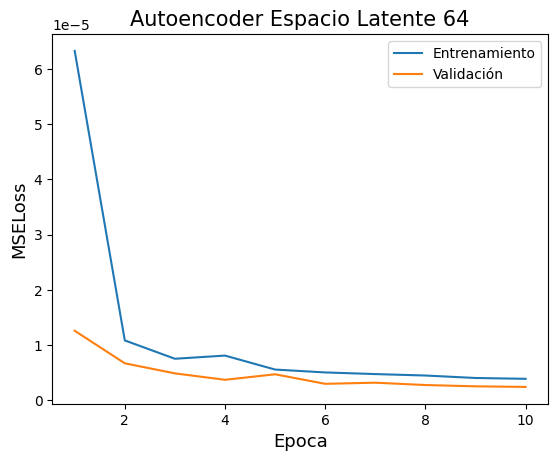

In [ ]:
epocas_x=np.arange(1,11)
plt.plot(epocas_x, trainer.train_losses, label="Entrenamiento")
plt.plot(epocas_x, trainer.val_losses, label="Validación")
plt.title("Autoencoder Espacio Latente 64", fontsize=15)
plt.xlabel("Epoca", fontsize=13)
plt.ylabel("MSELoss", fontsize=13)
plt.legend()
plt.show()

In [ ]:
# Definir parámetros para las capas convolucionales 32 latent size
autoencoder32 = Autoencoder(latent_size=32)
# Crea una instancia del entrenador
trainer32 = AutoencoderTrainer(model=autoencoder32, dataloaders=dataloaders, num_epochs=10, learning_rate=0.001)
# Entrena el modelo
trainer32.train()
# Imprime las listas de pérdidas para análisis posterior
print("Train Losses:", trainer32.train_losses)
print("Validation Losses:", trainer32.val_losses)

Epoch 1/10, Train Loss: 7.790809743599219e-05, Val Loss: 2.012645853068543e-05
Epoch 2/10, Train Loss: 1.5530886303086473e-05, Val Loss: 9.583519608884467e-06
Epoch 3/10, Train Loss: 1.0783914493547284e-05, Val Loss: 6.0152230285618155e-06
Epoch 4/10, Train Loss: 8.339926063885367e-06, Val Loss: 5.688715579835265e-06
Epoch 5/10, Train Loss: 9.172651268797868e-06, Val Loss: 6.48458440182389e-06
Epoch 6/10, Train Loss: 6.352873769621036e-06, Val Loss: 3.5802767416211823e-06
Epoch 7/10, Train Loss: 5.891694577917463e-06, Val Loss: 3.37837066832693e-06
Epoch 8/10, Train Loss: 5.417622873165623e-06, Val Loss: 3.1342800871143457e-06
Epoch 9/10, Train Loss: 4.998841245543419e-06, Val Loss: 2.8795041733086655e-06
Epoch 10/10, Train Loss: 5.035577535207848e-06, Val Loss: 2.679047399612649e-06
Train Losses: [7.790809743599219e-05, 1.5530886303086473e-05, 1.0783914493547284e-05, 8.339926063885367e-06, 9.172651268797868e-06, 6.352873769621036e-06, 5.891694577917463e-06, 5.417622873165623e-06, 4.99

In [ ]:
# salvar los modelos
path_autoencoder32 = os.path.join("/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis", "MODELS", "autoencoder32.pt")
torch.save(autoencoder32, path_autoencoder32)
path_best_autoencoder32 = os.path.join("/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis", "MODELS", "best_autoencoder32.pt")
best_autoencoder32 = deepcopy(autoencoder32.state_dict())
torch.save(best_autoencoder32, path_best_autoencoder32)

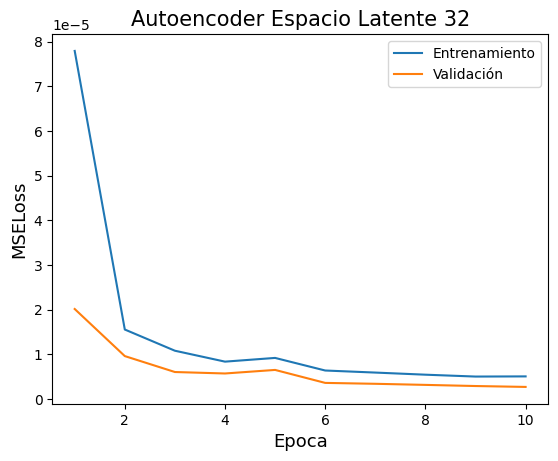

In [ ]:
epocas_x=np.arange(1,11)
plt.plot(epocas_x, trainer32.train_losses, label="Entrenamiento")
plt.plot(epocas_x, trainer32.val_losses, label="Validación")
plt.title("Autoencoder Espacio Latente 32", fontsize=15)
plt.xlabel("Epoca", fontsize=13)
plt.ylabel("MSELoss", fontsize=13)
plt.legend()
plt.show()

In [ ]:
# Definir parámetros para las capas convolucionales 16 latent size
autoencoder16 = Autoencoder(latent_size=16)
# Crea una instancia del entrenador
trainer16 = AutoencoderTrainer(model=autoencoder16, dataloaders=dataloaders, num_epochs=10, learning_rate=0.001)
# Entrena el modelo
trainer16.train()
# Imprime las listas de pérdidas para análisis posterior
print("Train Losses:", trainer16.train_losses)
print("Validation Losses:", trainer16.val_losses)

Epoch 1/10, Train Loss: 9.342439922333163e-05, Val Loss: 1.4842819584155577e-05
Epoch 2/10, Train Loss: 1.4596499084552517e-05, Val Loss: 9.771057519569884e-06
Epoch 3/10, Train Loss: 1.0996287579874066e-05, Val Loss: 7.593948413984518e-06
Epoch 4/10, Train Loss: 8.961173188279337e-06, Val Loss: 5.5864336615779e-06
Epoch 5/10, Train Loss: 7.627296245908799e-06, Val Loss: 5.022210864837493e-06
Epoch 6/10, Train Loss: 6.955384870138375e-06, Val Loss: 4.250144101804564e-06
Epoch 7/10, Train Loss: 6.055622671423238e-06, Val Loss: 4.036593749609145e-06
Epoch 8/10, Train Loss: 5.595839800837196e-06, Val Loss: 3.699134572176832e-06
Epoch 9/10, Train Loss: 5.4981170301074504e-06, Val Loss: 6.384496741602539e-06
Epoch 10/10, Train Loss: 5.143936062515298e-06, Val Loss: 3.631289707938514e-06
Train Losses: [9.342439922333163e-05, 1.4596499084552517e-05, 1.0996287579874066e-05, 8.961173188279337e-06, 7.627296245908799e-06, 6.955384870138375e-06, 6.055622671423238e-06, 5.595839800837196e-06, 5.4981

In [ ]:
# salvar los modelos
path_autoencoder16 = os.path.join("/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis", "MODELS", "autoencoder16.pt")
torch.save(autoencoder16, path_autoencoder16)
path_best_autoencoder16 = os.path.join("/content/drive/MyDrive/IA/GlobalOceanPhysicsReanalysis", "MODELS", "best_autoencoder16.pt")
best_autoencoder16 = deepcopy(autoencoder16.state_dict())
torch.save(best_autoencoder16, path_best_autoencoder16)

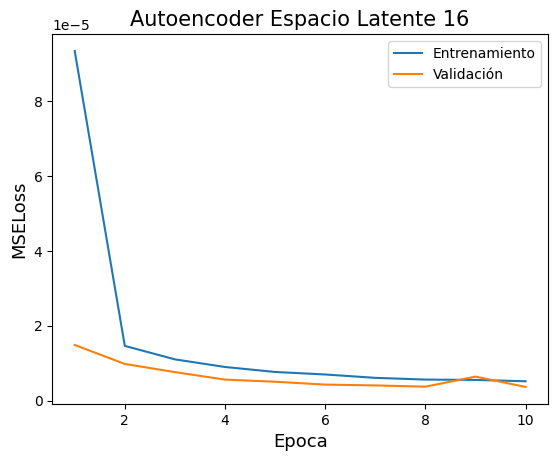

In [ ]:
epocas_x=np.arange(1,11)
plt.plot(epocas_x, trainer16.train_losses, label="Entrenamiento")
plt.plot(epocas_x, trainer16.val_losses, label="Validación")
plt.title("Autoencoder Espacio Latente 16", fontsize=15)
plt.xlabel("Epoca", fontsize=13)
plt.ylabel("MSELoss", fontsize=13)
plt.legend()
plt.show()

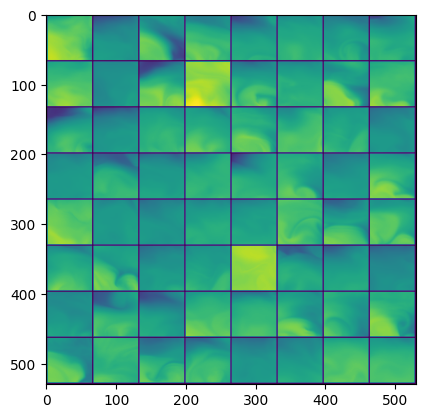

In [ ]:
#autoencoder(test_dataset)
# get some random training images
import torchvision
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="viridis")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(test_dataloader)
temperatura_test = next(dataiter)

# create grid of images
temperatura_grid = torchvision.utils.make_grid(temperatura_test)

# show images
matplotlib_imshow(temperatura_grid, one_channel=True)

# write to tensorboard
# writer.add_image('four_fashion_mnist_images', temperatura_grid)


In [ ]:
reconstruccion, latent_space = autoencoder(temperatura_test)

ValueError: ignored

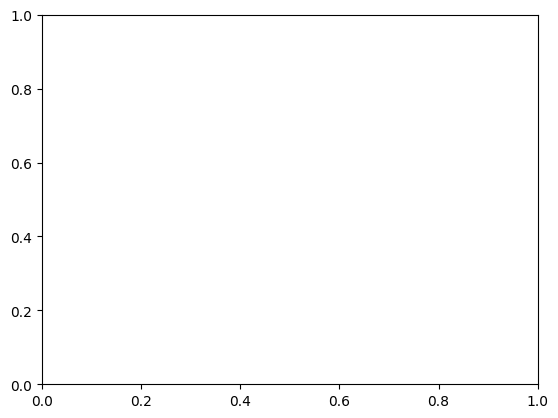

In [ ]:
plt.plot(reconstruccion[1])